In [2]:
!mkdir -p historical_data

!curl -L https://gist.githubusercontent.com/nicholascc/39df3671b93665861a69e295bcaa50ca/raw/93cd0147900fc822b758ea6df0d19ac4c41b8c95/orders.csv -o historical_data/orders.csv
!curl -L https://gist.githubusercontent.com/nicholascc/39df3671b93665861a69e295bcaa50ca/raw/93cd0147900fc822b758ea6df0d19ac4c41b8c95/trades.csv -o historical_data/trades.csv

!echo "Files downloaded successfully to historical_data/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2411k  100 2411k    0     0  7454k      0 --:--:-- --:--:-- --:--:-- 7466k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2512k  100 2512k    0     0  10.8M      0 --:--:-- --:--:-- --:--:-- 10.8M
Files downloaded successfully to historical_data/


In [3]:
import pandas as pd

# Load data
orders = pd.read_csv('historical_data/orders.csv', parse_dates=['timestamp'])
trades = pd.read_csv('historical_data/trades.csv', parse_dates=['transaction_timestamp'])


In [4]:
trades

,transaction_id,transaction_timestamp,price,size,market_name,days_back
0,7900,2025-02-11 21:03:11+00:00,136.5,4.0,alpha,6
1,7900,2025-02-11 21:03:11+00:00,128.5,4.0,alpha,6
2,7900,2025-02-11 21:03:11+00:00,121.0,4.0,alpha,6
3,7900,2025-02-11 21:03:11+00:00,128.0,4.0,alpha,6
4,7900,2025-02-11 21:03:11+00:00,120.5,4.0,alpha,6
...,...,...,...,...,...,...
51155,96570,2025-02-16 22:41:59+00:00,133.5,1.0,bravo,1
51156,96570,2025-02-16 22:41:59+00:00,134.0,1.5,bravo,1
51157,96737,2025-02-16 22:42:03+00:00,113.0,2.5,foxtrot,1
51158,96776,2025-02-16 22:42:07+00:00,133.5,2.5,bravo,1


In [5]:
# Process each market
market_grids = {}
for market in orders['market_name'].unique():
    # Filter market data
    mkt_orders = orders[orders['market_name'] == market].set_index('timestamp')
    mkt_trades = trades[trades['market_name'] == market].set_index('transaction_timestamp')
    
    # Create minute grids
    order_grid = mkt_orders.groupby(pd.Grouper(freq='1Min')).last()
    trade_grid = mkt_trades.groupby(pd.Grouper(freq='1Min')).agg({
        'price': 'last',
        'size': 'last'
    }).rename(columns={'price': 'last_trade_price', 'size': 'last_trade_size'})
    
    # Combine and store
    market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')

# Example: Look at first market's data
first_market = list(market_grids.keys())[0]
print(f"\nSample of {first_market} market grid:")
display(market_grids[first_market].head())


Sample of alpha market grid:


/tmp/ipykernel_44655/298827933.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
/tmp/ipykernel_44655/298827933.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
/tmp/ipykernel_44655/298827933.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
/tmp/ipykernel_44655/298827933.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.

,market_name,transaction_id,best_bid_price,best_bid_size,best_offer_price,best_offer_size,days_back,last_trade_price,last_trade_size
2025-02-11 21:02:00+00:00,alpha,6228.0,119.5,4.0,120.5,4.0,6.0,NaN,NaN
2025-02-11 21:03:00+00:00,alpha,8589.0,134.0,3.5,135.0,4.0,6.0,134.0,0.5
2025-02-11 21:04:00+00:00,alpha,9260.0,133.0,0.1,134.0,4.0,6.0,133.0,2.5
2025-02-11 21:05:00+00:00,alpha,10265.0,132.5,1.7,133.5,4.0,6.0,132.5,1.2
2025-02-11 21:06:00+00:00,alpha,11042.0,131.5,2.2,133.0,1.3,6.0,131.5,1.8


In [6]:
def plot_last_trade_price_night(market_name, day):
    import matplotlib.pyplot as plt
    import pandas as pd

    if market_name not in market_grids:
        print(f"Market '{market_name}' not found.")
        return

    df = market_grids[market_name]

    # Filter to the specified day first
    try:
        df_day = df.loc[str(day)]
    except Exception as e:
        print(f"Error filtering data for day {day}: {e}")
        return

    # Then filter to times between 21:00 and 23:00
    df_filtered = df_day.between_time('21:03', '23:00')
    
    if 'last_trade_price' not in df_filtered.columns:
        print("The 'last_trade_price' column is missing from the data.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(df_filtered.index, df_filtered['last_trade_price'], marker='o', linestyle='-')
    plt.title(f"Last Trade Price for {market_name} on {day} (21:00-23:00)")
    plt.xlabel("Time")
    plt.ylabel("Last Trade Price")
    plt.grid(True)
    plt.show()

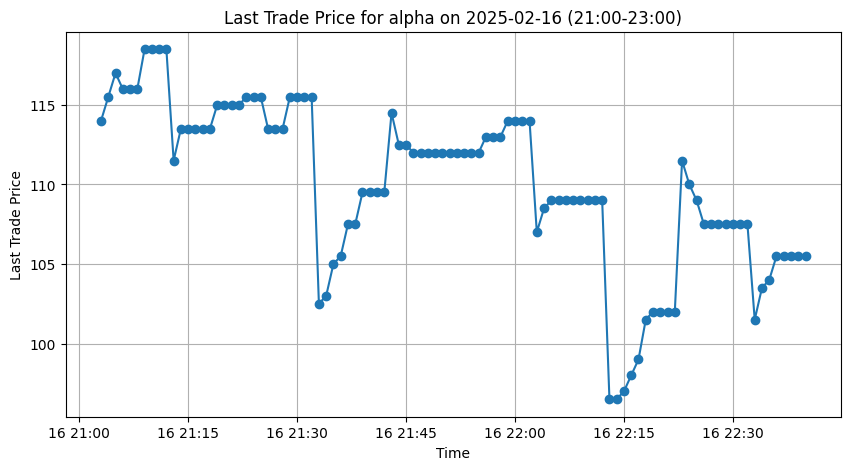

In [7]:
plot_last_trade_price_night("alpha", "2025-02-16")

In [8]:
def list_largest_absolute_moves(market_name, top_n=10):
    """
    List the minutes with the largest absolute move in last trade price for a given market.
    
    Parameters:
        market_name (str): The market name (e.g., "alpha").
        top_n (int): Number of largest moves to list.
        
    Returns:
        DataFrame: A DataFrame with the timestamp, last_trade_price, and absolute move.
    """
    import pandas as pd

    # Check that the market exists in our gridded data
    if market_name not in market_grids:
        print(f"Market '{market_name}' not found.")
        return
    
    # Retrieve the market DataFrame
    df = market_grids[market_name]
    
    # Ensure that the required column exists
    if 'last_trade_price' not in df.columns:
        print("The 'last_trade_price' column is missing from the data.")
        return
    
    # Create a copy of the DataFrame so as not to modify the original data
    df_copy = df.copy()
    # Compute the absolute difference of last_trade_price between consecutive minutes
    df_copy['abs_move'] = df_copy['last_trade_price'].diff().abs()
    
    # Drop the first row which will have an NaN move value, then sort descending by 'abs_move'
    df_copy = df_copy.dropna(subset=['abs_move'])
    largest_moves = df_copy.sort_values(by='abs_move', ascending=False).head(top_n)
    
    print(largest_moves[['last_trade_price', 'abs_move']])
    return largest_moves

# Example usage:
list_largest_absolute_moves("alpha", top_n=20)

                           last_trade_price  abs_move
2025-02-15 21:03:00+00:00             121.0      31.0
2025-02-13 21:33:00+00:00             144.0      17.0
2025-02-15 22:13:00+00:00             129.0      16.0
2025-02-11 21:43:00+00:00             142.5      15.5
2025-02-14 21:33:00+00:00             148.0      15.0
2025-02-12 21:43:00+00:00             108.0      15.0
2025-02-11 21:13:00+00:00             114.0      14.5
2025-02-12 22:23:00+00:00             129.0      14.0
2025-02-16 21:33:00+00:00             102.5      13.0
2025-02-14 22:33:00+00:00             160.0      12.5
2025-02-16 22:13:00+00:00              96.5      12.5
2025-02-12 22:33:00+00:00             110.5      12.5
2025-02-14 21:23:00+00:00             138.0      12.5
2025-02-15 21:43:00+00:00             113.5      12.5
2025-02-13 22:13:00+00:00             148.0      11.5
2025-02-11 22:33:00+00:00             116.0      11.0
2025-02-12 22:03:00+00:00             106.5      10.5
2025-02-11 22:13:00+00:00   

,market_name,transaction_id,best_bid_price,best_bid_size,best_offer_price,best_offer_size,days_back,last_trade_price,last_trade_size,abs_move
2025-02-15 21:03:00+00:00,alpha,7427.0,121.0,1.74,122.0,4.0,2.0,121.0,1.26,31.0
2025-02-13 21:33:00+00:00,alpha,34501.0,143.0,0.50,144.0,1.5,4.0,144.0,2.50,17.0
2025-02-15 22:13:00+00:00,alpha,70528.0,129.0,0.80,130.0,4.0,2.0,129.0,0.10,16.0
2025-02-11 21:43:00+00:00,alpha,44124.0,141.5,1.50,142.5,1.5,6.0,142.5,2.50,15.5
2025-02-14 21:33:00+00:00,alpha,34164.0,147.5,3.50,148.5,4.0,3.0,148.0,2.00,15.0
2025-02-12 21:43:00+00:00,alpha,43820.0,107.5,0.50,109.0,3.0,5.0,108.0,1.50,15.0
2025-02-11 21:13:00+00:00,alpha,17286.0,114.0,1.50,115.0,0.2,6.0,114.0,2.50,14.5
2025-02-12 22:23:00+00:00,alpha,81172.0,129.0,0.20,130.0,1.5,5.0,129.0,0.10,14.0
2025-02-16 21:33:00+00:00,alpha,33190.0,101.5,4.00,102.5,0.5,1.0,102.5,2.50,13.0
2025-02-14 22:33:00+00:00,alpha,89442.0,160.0,2.90,161.5,4.0,3.0,160.0,1.10,12.5


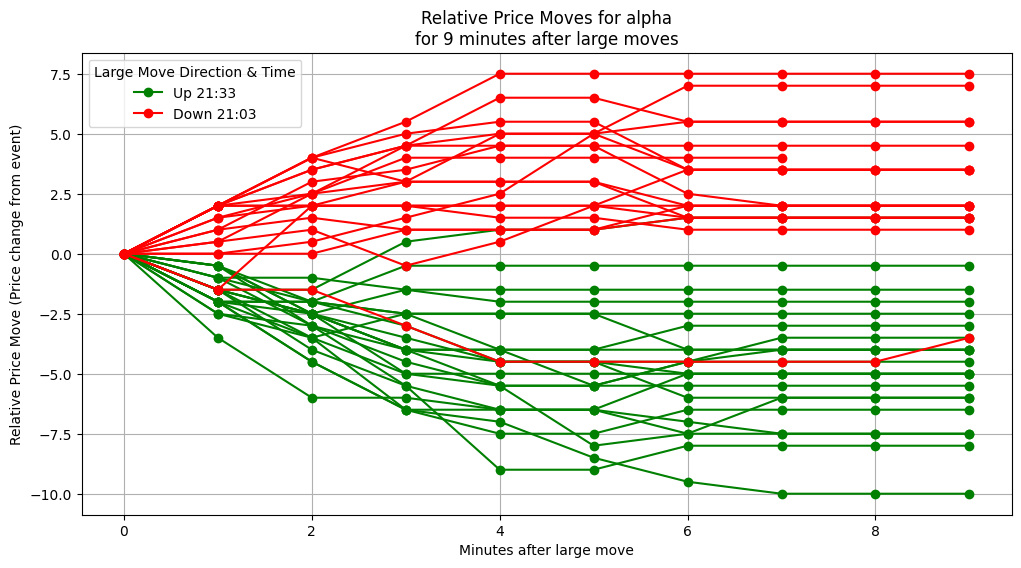

In [9]:
def plot_post_large_move_relative(market_name, top_n=10, minutes_after=10):
    """
    Plot the relative last trade price moves for the period following each of the largest moves.
    The price immediately after the move is set to 0. Events are split into those with 
    upward moves vs. downward moves.

    Parameters:
        market_name (str): The market name (e.g., "alpha").
        top_n (int): Number of largest moves to consider.
        minutes_after (int): Number of minutes following the move to plot.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Check market existence
    if market_name not in market_grids:
        print(f"Market '{market_name}' not found.")
        return

    df = market_grids[market_name]
    if 'last_trade_price' not in df.columns:
        print("The 'last_trade_price' column is missing from the data.")
        return

    # Create a copy and compute both signed and absolute moves
    df_copy = df.copy()
    df_copy['price_change'] = df_copy['last_trade_price'].diff()
    df_copy['abs_move'] = df_copy['price_change'].abs()
    df_copy = df_copy.dropna(subset=['abs_move'])
    
    # Get the top_n largest moves based on the absolute move
    largest_moves = df_copy.sort_values(by='abs_move', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))

    # Separate upward and downward moves
    upward_moves = largest_moves[largest_moves['price_change'] > 0]
    downward_moves = largest_moves[largest_moves['price_change'] < 0]

    for event_time, row in upward_moves.iterrows():
        # Baseline is the price at the event time (immediately after the move)
        baseline = df.loc[event_time, 'last_trade_price']
        window_end = event_time + pd.Timedelta(minutes=minutes_after)
        post_event_data = df.loc[event_time:window_end]
        if post_event_data.empty:
            continue
        # Compute relative difference with the baseline
        relative = post_event_data['last_trade_price'] - baseline
        # Compute offset in minutes from event time
        offset = (post_event_data.index - event_time) / pd.Timedelta("1min")
        plt.plot(offset, relative,
                 marker='o',
                 linestyle='-',
                 color='green',
                 label=f"Up {event_time.strftime('%H:%M')}" if event_time==upward_moves.index[0] else "")

    for event_time, row in downward_moves.iterrows():
        # Baseline is the price at the event time (immediately after the move)
        baseline = df.loc[event_time, 'last_trade_price']
        window_end = event_time + pd.Timedelta(minutes=minutes_after)
        post_event_data = df.loc[event_time:window_end]
        if post_event_data.empty:
            continue
        # Compute relative difference with the baseline
        relative = post_event_data['last_trade_price'] - baseline
        # Compute offset in minutes from event time
        offset = (post_event_data.index - event_time) / pd.Timedelta("1min")
        plt.plot(offset, relative,
                 marker='o',
                 linestyle='-',
                 color='red',
                 label=f"Down {event_time.strftime('%H:%M')}" if event_time==downward_moves.index[0] else "")

    plt.xlabel("Minutes after large move")
    plt.ylabel("Relative Price Move (Price change from event)")
    plt.title(f"Relative Price Moves for {market_name}\nfor {minutes_after} minutes after large moves")
    plt.legend(title="Large Move Direction & Time")
    plt.grid(True)
    plt.show()

# Example usage:
plot_post_large_move_relative("alpha", top_n=40, minutes_after=9)

Plotting for market: alpha


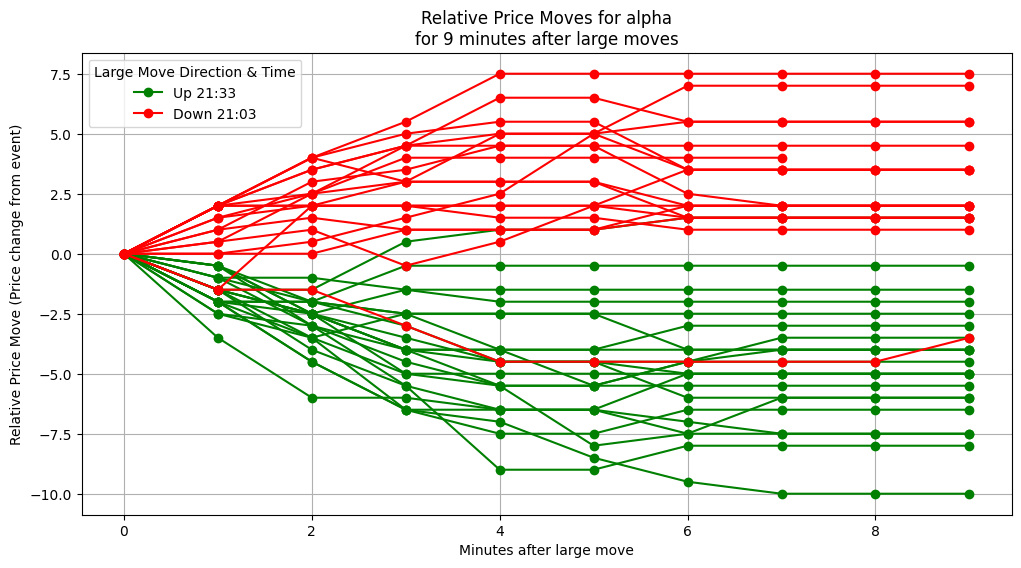

Plotting for market: bravo


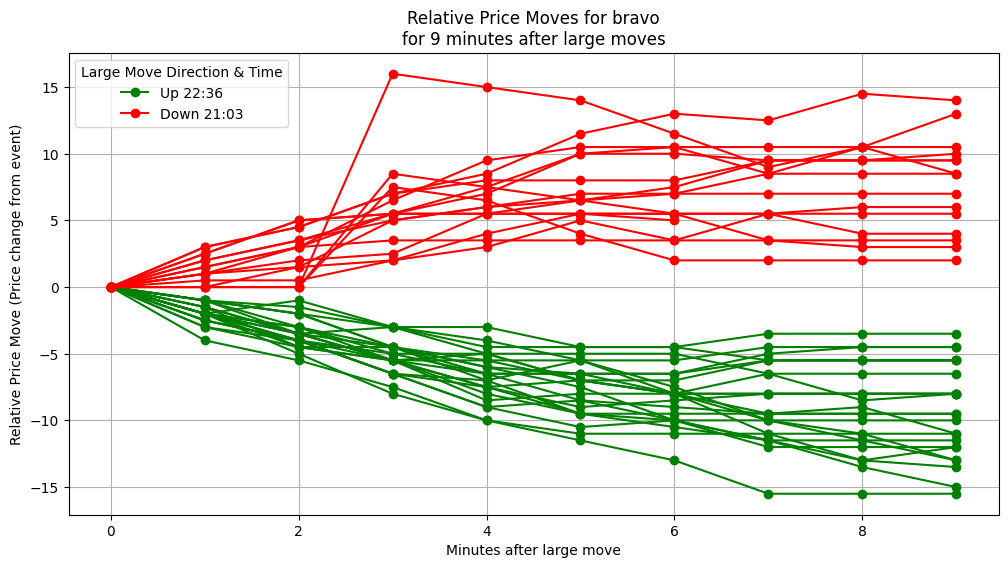

Plotting for market: charlie


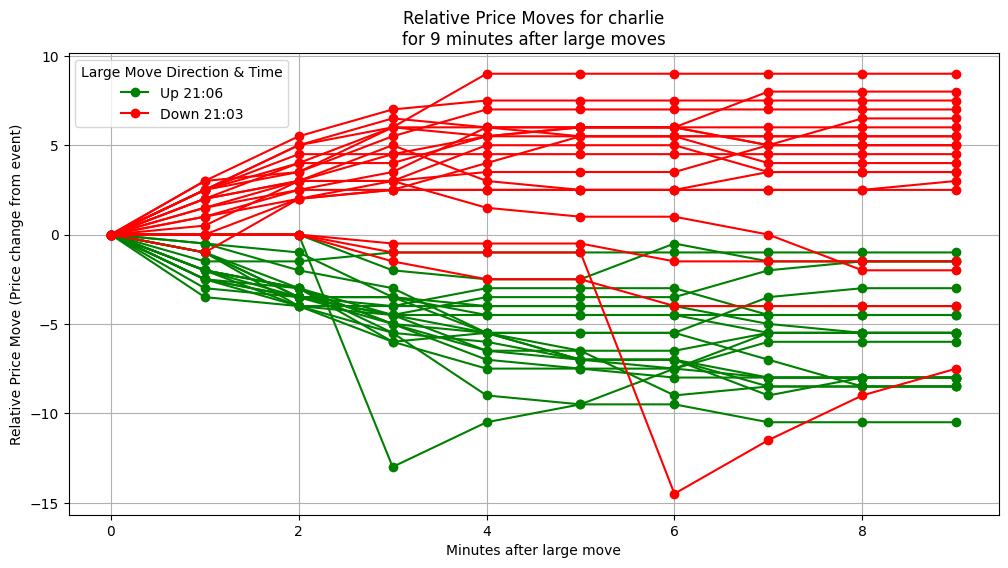

Plotting for market: delta


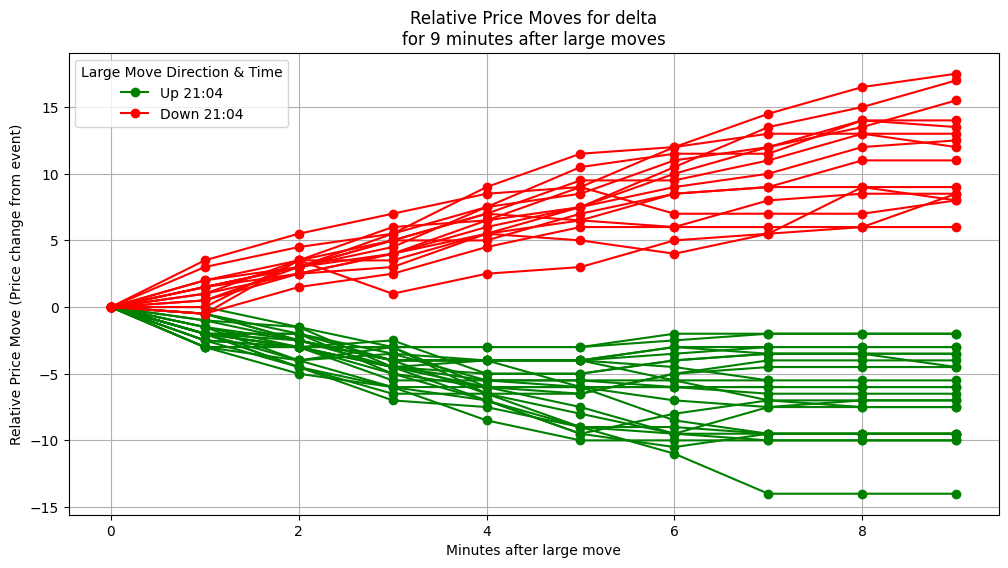

Plotting for market: echo


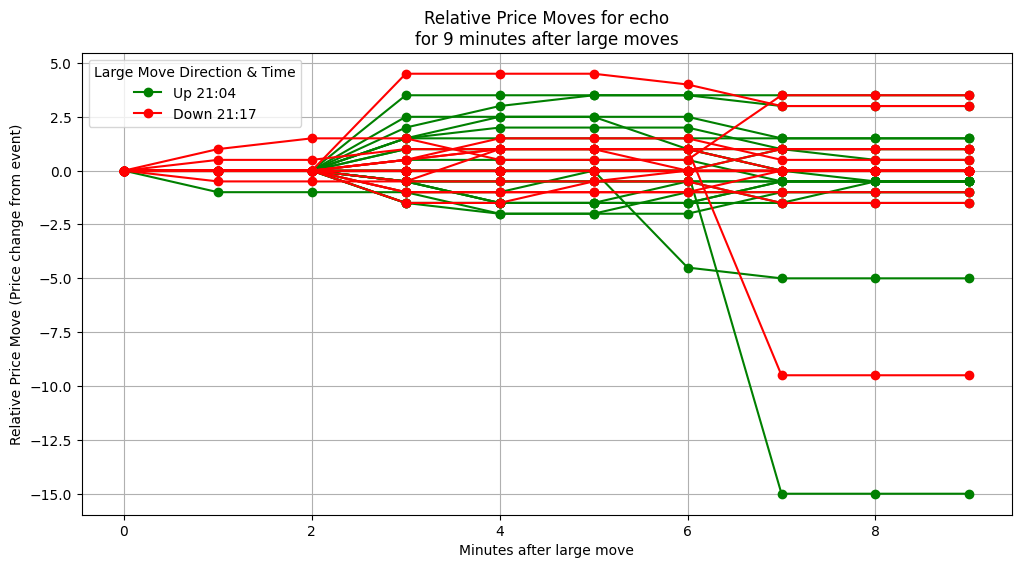

Plotting for market: foxtrot


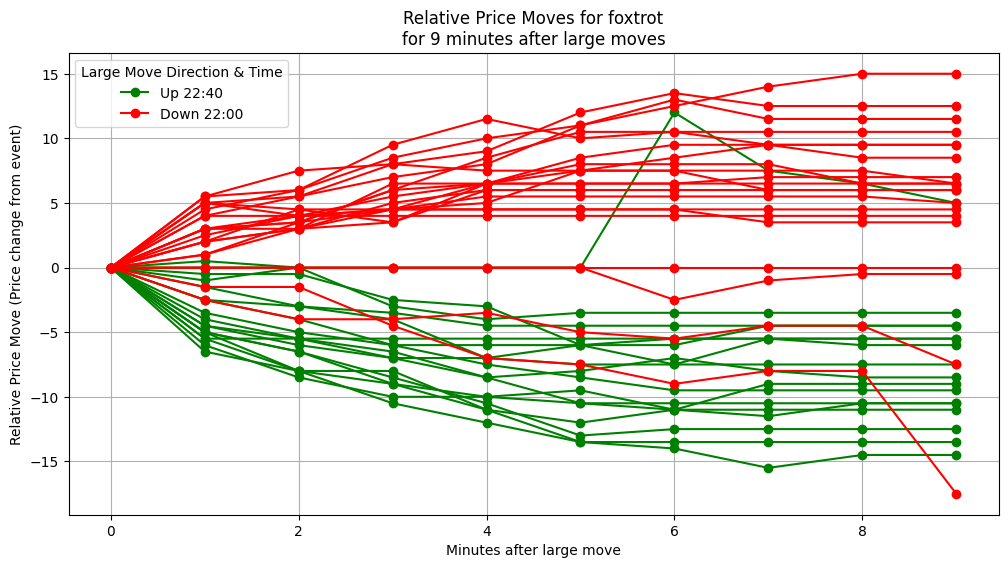

Plotting for market: golf


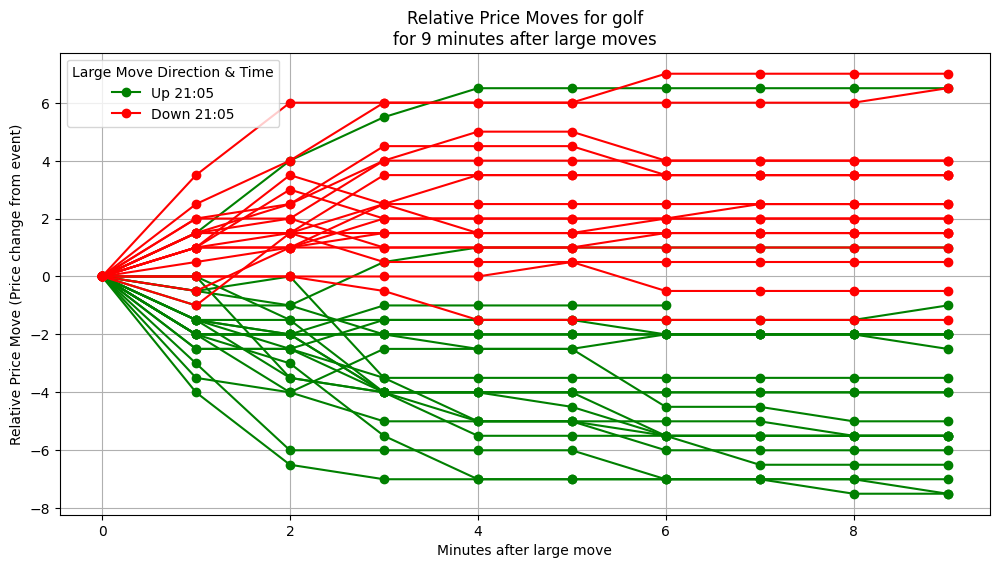

Plotting for market: hotel


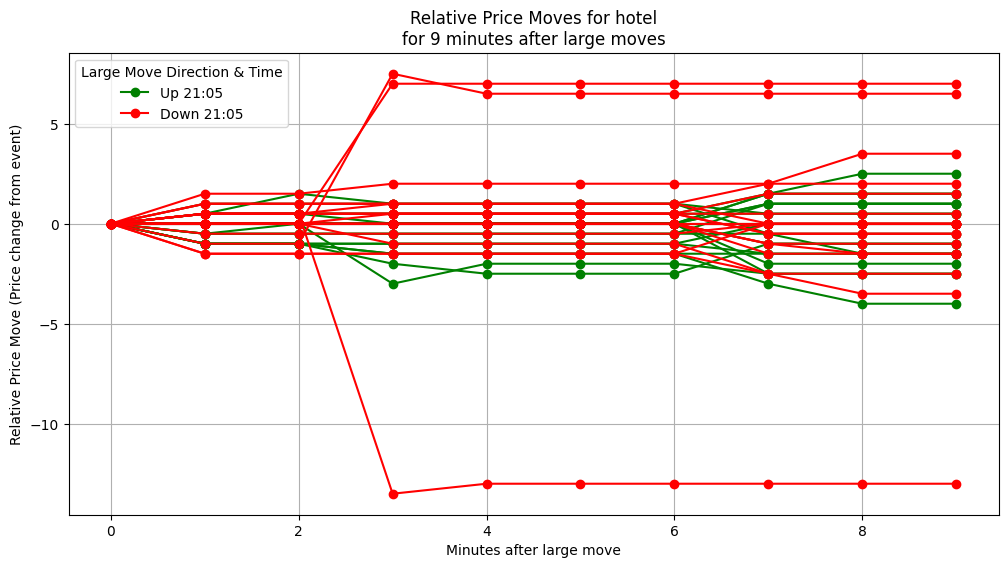

Plotting for market: india


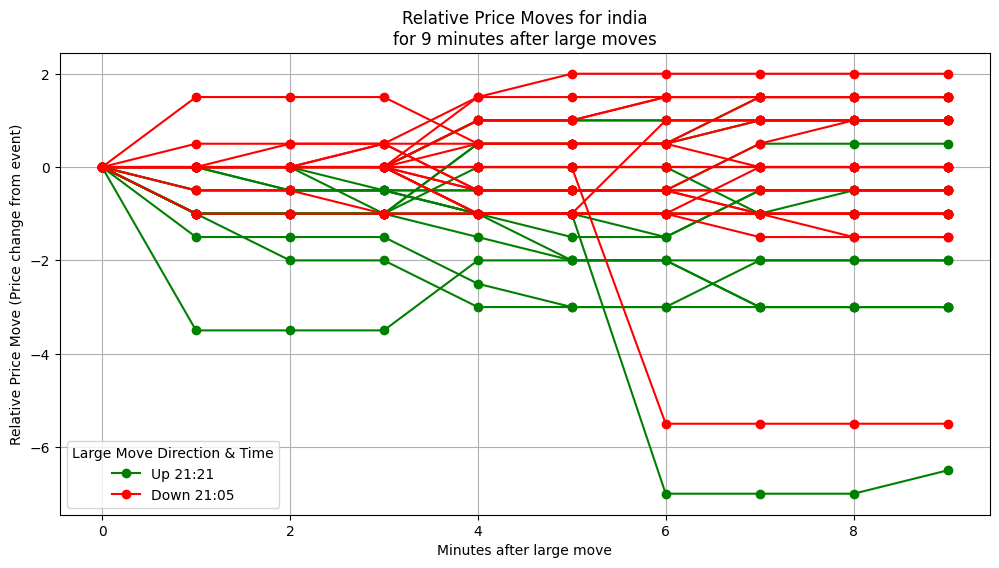

In [10]:
def plot_post_large_move_relative_all(market_names, top_n=40, minutes_after=9):
    """
    For each market symbol in market_names, plot the relative price moves for
    the minutes following each large move in a separate plot.

    Parameters:
        market_names (list): List of market symbols (e.g., ["alpha", "bravo"]).
        top_n (int): Number of largest moves to consider.
        minutes_after (int): Number of minutes following the move to plot.
    """
    for market in market_names:
        print(f"Plotting for market: {market}")
        # This call creates its own figure and shows the plot
        plot_post_large_move_relative(market, top_n=top_n, minutes_after=minutes_after)

# Example usage:
plot_post_large_move_relative_all(["alpha", "bravo", "charlie", "delta", "echo", "foxtrot", "golf", "hotel", "india"])